# Inference Pipeline and Format Selection

This notebook demonstrates model format selection and the inference pipeline. Inspired by [Intro to Inference: How to Run AI Models on a GPU](https://developers.google.com/learn/pathways/ai-models-on-gpu-intro).

Run the setup cell first. Use **Runtime > Change runtime type > GPU** in Colab for faster inference.

**Configure runtime first:** Runtime > Change runtime type > Hardware accelerator: **GPU** (T4) > Save.

In [1]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/Project-Insight.git")
    get_ipython().run_line_magic("cd", "Project-Insight")
    get_ipython().system("pip install -q -r requirements.txt")
except Exception:
    pass

/content/Project-Insight


In [2]:
# Setup: Colab runs from repo root after clone
import sys
from pathlib import Path
ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

ROOT=/content/Project-Insight


## 1. Format selection by use case

In [3]:
from src.inference.format_selector import select_format

for use_case in ["research", "sharing", "local", "production", "portable"]:
    fmt, rationale = select_format(use_case, hardware="gpu")
    print(f"{use_case}: {fmt}")
    print(f"  {rationale[:85]}...")
    print()

research: safetensors
  Fast, secure weight serialization. Memory-mapped loading, no arbitrary code execution...

sharing: safetensors
  Fast, secure weight serialization. Memory-mapped loading, no arbitrary code execution...

local: gguf
  Compact, quantized format for local inference. Powers llama.cpp and run-on-laptop wor...

production: tensorrt
  Compiled engine for NVIDIA GPUs. Pre-optimized kernels, lowest latency and highest th...

portable: onnx
  Graph-level interchange format. Framework-agnostic, runs on ONNX Runtime, OpenVINO, T...



## 2. Inference metrics (p50, p90, throughput)

In [4]:
from src.inference.metrics import compute_metrics

total_latencies = [1.2, 1.1, 1.3, 1.0, 1.2]
first_token_latencies = [0.1, 0.09, 0.11, 0.1, 0.1]
token_counts = [64, 64, 64, 64, 64]

metrics = compute_metrics(
    total_latencies=total_latencies,
    first_token_latencies=first_token_latencies,
    token_counts=token_counts,
)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

p50_latency_s: 1.2000
p90_latency_s: 1.2600
p50_ttft_s: 0.1000
p90_ttft_s: 0.1060
throughput_sustained_tok_s: 55.1724


## 3. Inference pipeline with Gemma 2 2B (data-grounded telemetry Q&A)

Uses **Google Gemma 2 2B Instruct** to answer questions about fleet telemetry — the same data from notebook 01. This is the **local** version of the telemetry-to-insight pipeline (notebook 03 scales this to NIM on GKE).

**Setup (one-time):**
1. Accept the license at [google/gemma-2-2b-it](https://huggingface.co/google/gemma-2-2b-it)
2. Create a Read token at [huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)
3. In Colab: click the **key icon** (Secrets) > add `HF_TOKEN` with your token > toggle Notebook access ON

In [5]:
# Load telemetry data (same as notebooks 01 & 03) — generates synthetic data if missing
import subprocess
from pathlib import Path

data_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
if not data_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", "100000", "--output-dir", "data/synthetic", "--format", "parquet",
    ], check=True, cwd=str(ROOT))

from src.query.engine import TelemetryQueryEngine

engine = TelemetryQueryEngine(
    data_path=str(data_path),
    nim_base_url="http://localhost:8000",  # not used — we call the local model
    max_context_rows=500,
)
print(f"Telemetry data loaded. Path: {data_path}")

Telemetry data loaded. Path: /content/Project-Insight/data/synthetic/fleet_telemetry.parquet


In [6]:
# Inference pipeline with Gemma 2 2B (requires GPU runtime + HF token)
import os
import warnings
warnings.filterwarnings("ignore", message=".*torch_dtype.*")

# Authenticate with HuggingFace (reads HF_TOKEN from Colab Secrets)
try:
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    print("HF token loaded from Colab Secrets.")
except Exception:
    if "HF_TOKEN" not in os.environ:
        print("WARNING: Set HF_TOKEN in Colab Secrets (key icon) or as environment variable.")

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.inference.pipeline import InferencePipeline

model_id = "google/gemma-2-2b-it"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Model: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
model = model.to(device)

pipe = InferencePipeline(model, tokenizer, device=device, max_new_tokens=128)

import time
from src.query.prompts import SYSTEM_PROMPT, format_user_query
from src.query.query_config import QUERY_CONFIG

def clean_response(raw_text):
    """Clean generated text: strip any remaining chat tags, trim to last complete sentence."""
    text = raw_text
    for tag in ["<start_of_turn>", "<end_of_turn>", "<bos>", "<eos>", "model\n", "user\n"]:
        text = text.replace(tag, "")
    text = text.strip()
    if text and text[-1] not in ".!?":
        last_end = max(text.rfind("."), text.rfind("!"), text.rfind("?"))
        if last_end > 0:
            text = text[:last_end + 1]
    return text.strip()

results_02 = []
for cfg in QUERY_CONFIG:
    q = cfg["query"]
    if cfg.get("skip_data"):
        context = "No telemetry data — this is a general knowledge question about ML deployment."
    else:
        df = engine.retrieve(
            vehicle_ids=cfg.get("vehicle_ids"),
            sensor_type=cfg.get("sensor_type"),
            brake_threshold=cfg.get("brake_threshold"),
        )
        context = engine._data_to_context(df, max_rows=50)
    user_msg = f"{SYSTEM_PROMPT}\n\n{format_user_query(q, context, max_context_chars=3000)}"
    chat_prompt = f"<start_of_turn>user\n{user_msg}<end_of_turn>\n<start_of_turn>model\n"
    t0 = time.perf_counter()
    out = pipe.generate([chat_prompt], max_new_tokens=128)
    latency_s = time.perf_counter() - t0
    response = clean_response(out[0])
    results_02.append({
        "id": cfg.get("id", ""),
        "label": cfg.get("label", q[:30]),
        "query": q,
        "answer": response,
        "latency_s": latency_s,
        "response_chars": len(response),
    })
    print(f"Q: {q}")
    print(f"A: {response}")
    print(f"  [{latency_s:.2f}s | {len(response)} chars]")
    print("-" * 60)

HF token loaded from Colab Secrets.
Device: cuda
Model: google/gemma-2-2b-it


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/288 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Q: What was the peak brake pressure percentage in vehicle V001?
A: The peak brake pressure percentage in vehicle V001 was 99.920210%.
  [3.16s | 66 chars]
------------------------------------------------------------
Q: What is the maximum brake_pressure_pct value across all vehicles? Which vehicle had it?
A: The maximum brake_pressure_pct value is 99.981474%. Vehicle V009 had this value.
  [2.14s | 80 chars]
------------------------------------------------------------
Q: What is the average vehicle_speed_kmh for each vehicle? List from fastest to slowest.
A: The average vehicle_speed_kmh is 20000.000000 km/h.
  [1.80s | 51 chars]
------------------------------------------------------------
Q: Provide a brief fleet health summary: average speed, average throttle, average brake pressure percentage.
A: Average vehicle speed: 49.7 km/h
Average throttle position: 49.9%
Average brake pressure: 59.
  [2.16s | 93 chars]
------------------------------------------------------------
Q: How many r

### Results summary: Local Gemma 2 2B

Latency and response metrics per query.

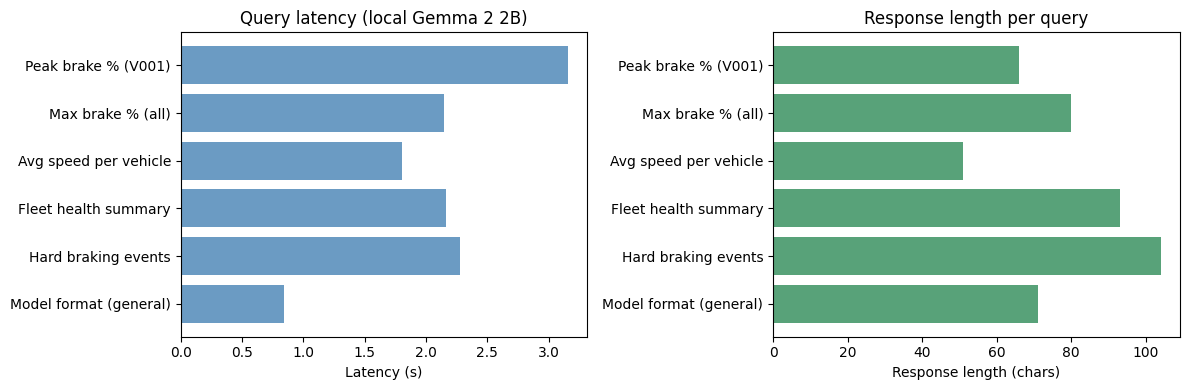

Total time: 12.38s | Avg latency: 2.06s | Model: google/gemma-2-2b-it


In [7]:
import matplotlib.pyplot as plt

labels = [r["label"] for r in results_02]
latencies = [r["latency_s"] for r in results_02]
chars = [r["response_chars"] for r in results_02]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(labels, latencies, color="steelblue", alpha=0.8)
axes[0].set_xlabel("Latency (s)")
axes[0].set_title("Query latency (local Gemma 2 2B)")
axes[0].invert_yaxis()

axes[1].barh(labels, chars, color="seagreen", alpha=0.8)
axes[1].set_xlabel("Response length (chars)")
axes[1].set_title("Response length per query")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Total time: {sum(latencies):.2f}s | Avg latency: {sum(latencies)/len(latencies):.2f}s | Model: {model_id}")